# Ekşi Sözlük EDA & Baselines

Bu notebook, veritabanındaki girdileri hızlıca inceleyip üç temel akışı çalıştırmak için hazırlandı:

1. **EDA** – Tablonun kapsama, kayıp veri, metin uzunluğu ve tekrar analizleri.
2. **Topic sınıflaması** – Top-K topic başlığı + `OTHER` kovasına karşı TF-IDF + LinearSVC.
3. **Cluster ve trend keşfi** – UMAP + HDBSCAN ile konu kümeleri, zaman serisi ile ani artış/düşüş tespiti.

Gerektiğinde parametreleri aşağıdaki konfigürasyon hücresinden değiştirebilirsiniz.

## Kurulum

Notebook aşağıdaki paketlere ihtiyaç duyar:

- `pandas`, `numpy`
- `scikit-learn`
- (opsiyonel) `umap-learn`, `hdbscan` – kümeleme için

Eksik modüller varsa `pip install pandas numpy scikit-learn umap-learn hdbscan` komutunu çalıştırın.

In [1]:
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from model_train import (
    load_entries_with_topics,
    report_basic_eda,
    train_baseline_favorites_classifier,
    train_topic_baseline,
    run_topic_clustering,
    analyze_topic_trends,
)

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")


## Konfigürasyon

Buradaki değerleri değiştirerek aynı hücrelerle farklı deneyler yapabilirsiniz.

In [2]:
DB_PATH = Path("../datasets/eksi.db")
SAMPLE_LIMIT = None  # Örn. 50000 ile daha hızlı iterasyon

TOP_K_TOPICS = 20
TIME_CUTOFF = "2025-10-01"  # Train <= cutoff, Test > cutoff; None → random split

BASELINE_SAMPLE = 40000  # favorites klasifikasyonu için, 0 → tüm veri
CLUSTER_SAMPLE = 20000   # clustering için örnek boyutu
TREND_FREQ = "W"         # Haftalık ("M" → aylık)
TREND_ZSCORE = 3.0

## Veri yükleme

Entries tablosunu topic metadatası ile birleştirip veri çerçevesi haline getirir.

In [3]:
entries_df = load_entries_with_topics(str(DB_PATH), limit=SAMPLE_LIMIT)
entries_df.head()

,entry_id,topic_id,topic_title,author_hash,favorites,created_at_ts,text_clean,crawl_ts,entry_length_chars,entry_length_tokens,created_date,created_hour,created_dayofweek
0,179182539,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,51d7b23f0c16697652bc651379fc72df5dcf830473f01a...,0,NaT,(bkz:\nhikikomori\n),2025-10-17 16:01:02.648953,18,3,NaT,NaN,NaN
1,179182582,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,919f0de4857308301bb41ee359f4f3792c8ba8ae8f59fa...,0,NaT,adamın saçını götüren abilerden biri kesmiş sa...,2025-10-17 16:01:02.648953,109,14,NaT,NaN,NaN
2,179182595,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,386a709cf2e70cb4b897506587b8363af1d0646fbac209...,0,NaT,depresyondaki birine çık dışarı dolaş demeyi b...,2025-10-17 16:01:02.648953,261,37,NaT,NaN,NaN
3,179182603,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,f439dcacb06677388e285d47873cc52f841fca1a95878e...,0,NaT,birde zorla traş ve banyo yaptırılarak normale...,2025-10-17 16:01:06.400294,305,41,NaT,NaN,NaN
4,179182691,8036823,3 yıldır evden çıkmayan gencin evden çıkarılması,1cb631b880b392c16542ae41875d2972fae63858be24b3...,0,NaT,karga tulumba alıp götürmek nasıl bir mantık y...,2025-10-17 16:01:06.400294,186,29,NaT,NaN,NaN


## Keşifsel veri analizi

In [4]:
report_basic_eda(entries_df)


=== Basic Shape ===
Rows: 214,241
Unique topics: 192
Unique authors: 59,589

=== Missing Values ===
topic_title          0
author_hash          0
favorites            0
created_at_ts    27288
text_clean           0

=== Entry Length (characters) ===
count    214241.000000
mean        504.284497
std        1927.517422
min           1.000000
50%         194.000000
75%         476.000000
90%        1106.000000
99%        4959.000000
max      689117.000000

=== Favorites ===
count    214241.0
mean          0.0
std           0.0
min           0.0
50%           0.0
75%           0.0
90%           0.0
99%           0.0
max           0.0

=== Top Topics (by entry count) ===
topic_title
aşk                            25987
donald trump                   17042
türkiye                        16712
amerika birleşik devletleri    15135
almanya                        10522
israil                          8659
elon musk                       7842
yunanistan                      4723
iran            

## (Opsiyonel) Favorites baseline

Favorit sayıları anlamlı değilse bu hücre uyarı verip atlayacaktır.

In [5]:
train_baseline_favorites_classifier(entries_df, sample_size=BASELINE_SAMPLE)

Baseline skipped: favorites lack variance after thresholding. Consider a different target (e.g., favorites >= 1) or fix data collection.


## Topic sınıflaması

Top-K topic başlığını koruyup diğerlerini `OTHER` kovasına atar. Zaman bazlı ayrım mümkün değilse random 80/20 split'e döner.

In [6]:
train_topic_baseline(
    entries_df,
    top_k=TOP_K_TOPICS,
    cutoff=TIME_CUTOFF,
)


=== Topic Classification Baseline ===
Split: Time split @ 2025-10-01
Train size: 174424, Test size: 12529
Label distribution (train):
topic_bucket
OTHER                             45490
aşk                               25932
donald trump                      16844
türkiye                           13234
amerika birleşik devletleri       10158
elon musk                          7826
almanya                            7125
israil                             6221
cem yılmaz                         4559
depresyon                          4123
mete gazoz                         3762
vedat milor                        3630
iran                               3551
yunanistan                         3540
rusya                              3129
kitaplıktaki en kıymetli kitap     3027
japonya                            3003
münir özkul                        2610
aydın doğu demirkol                2382
levent kırca                       2175
özgürlük                           2103
Label distri

## Topic cluster keşfi

UMAP + HDBSCAN çıktısı, kümeleri ve her kümeden birkaç örnek metni yazdırır. `umap-learn` veya `hdbscan` yoksa bilgilendirir.

In [7]:
run_topic_clustering(
    entries_df,
    sample_size=CLUSTER_SAMPLE,
)

Sampling 20,000 rows for clustering.

=== HDBSCAN Clusters ===
Cluster sizes:
cluster
18    1240
2      832
57     783
22     416
23     337
49     309
56     292
36     259
24     244
55     241
43     237
28     230
45     226
3      220
20     183
37     179
1      152
30     149
19     142
46     124
47     116
33     107
15     106
11      97
26      93
5       89
17      88
39      87
0       86
25      81
41      79
38      79
48      78
31      77
14      76
34      75
8       72
35      71
42      70
50      69
54      68
44      68
16      66
51      65
13      60
52      59
6       58
27      58
29      57
9       56
4       55
12      54
32      54
10      53
21      53
53      52
40      52
7       51
Noise points: 10,470

Sample texts per cluster (first 3 entries):

Cluster 18 (size=1240):
  1. cakil diye bir siiri var ki saniyorum asik olan insan hallerini anlatir. (bkz: cakil/10 ) yanlis demisim, aslinda sevdali demek lazim, evet boyle!
  2. trump gelmezse potansiyelini

## Zaman serisi & anomali tespiti

Topic başlıklarını haftalık veya aylık frekansla sayarak z-skoru yüksek patlamaları listeler.

In [8]:
trend_counts = analyze_topic_trends(
    entries_df,
    top_k=TOP_K_TOPICS,
    freq=TREND_FREQ,
    zscore_threshold=TREND_ZSCORE,
)
if trend_counts is not None:
    trend_counts.head()
else:
    print("Trend analizi için yeterli veri bulunamadı.")



=== Topic Timeline (oldest → newest snapshot) ===
    period                   topic_bucket  entry_count
1999-06-14                          OTHER            2
1999-06-28                          OTHER            4
1999-08-02                          OTHER            1
1999-08-16                          OTHER            2
1999-09-06                          OTHER            1
1999-11-15                        almanya            1
2000-02-28                        almanya            1
2001-06-18                        almanya            1
2001-07-16                        almanya            1
2001-11-26                        almanya            1
2000-01-24    amerika birleşik devletleri            1
2000-11-06    amerika birleşik devletleri            1
2000-11-20    amerika birleşik devletleri            1
2000-12-25    amerika birleşik devletleri            1
2001-07-16    amerika birleşik devletleri            1
2011-06-20            aydın doğu demirkol           11
2011-08-15    

## Timeline Görselleştirmesi

Seçili topicler için zaman serisi çizelgesi.


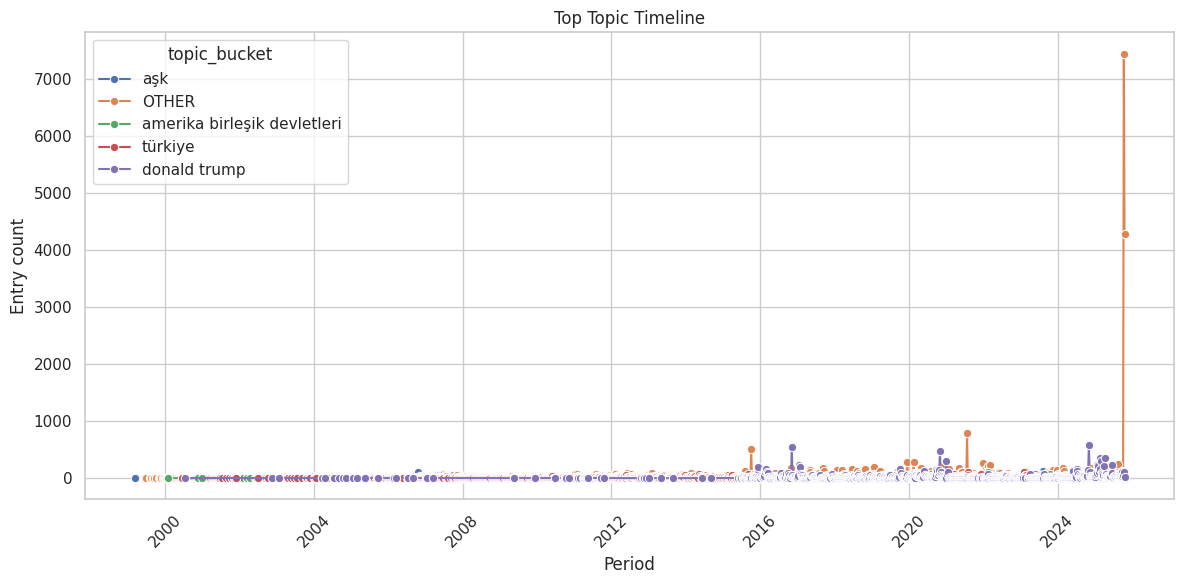

In [9]:
if trend_counts is not None and not trend_counts.empty:
    top_topics_for_plot = (
        trend_counts.groupby("topic_bucket")["entry_count"].sum().nlargest(5).index
    )
    plot_df = trend_counts[trend_counts["topic_bucket"].isin(top_topics_for_plot)].copy()
    plot_df = plot_df.sort_values(["period", "topic_bucket"])
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_df, x="period", y="entry_count", hue="topic_bucket", marker="o")
    plt.title("Top Topic Timeline")
    plt.xlabel("Period")
    plt.ylabel("Entry count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Trend datası boş, grafik çizilmedi.")
